In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

# External library imports
import datetime
import torch
import torch.nn as nn
import numpy as np
import random
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset, random_split


# internal library imports
from dataset import DebrisStatePairsDataset
from model import CNN, UNet
from train import TrainerPairs, CustomDebrisLoss
from util.setting_utils import set_seed




In [2]:
# Set the random seed for multiple libraries to ensure repeatability

set_seed(42)

In [3]:
# Parameters

root_dir = r'/home/tom/repos/dyna-landslide-surrogate/data_experiment'
checkpoint_dir = r'/home/tom/repos/dyna-landslide-surrogate/checkpoints'
batch_size = 32
split_proportions = (0.7, 0.15, 0.15)
epochs = 30

in_channels = 3  # Number of input channels (e.g., terrain, velocity, thickness)
out_channels = 2  # Number of output channels (e.g., next velocity, next thickness)

In [4]:
# Data set up

# Initialize dataset with scaling
dataset = DebrisStatePairsDataset(root_dir, array_size=256, apply_scaling=True)

# Split dataset into train, validation, and test sets and create dataloaders
train_loader, val_loader, test_loader = dataset.create_dataloaders(split_proportions, batch_size, random_state=42)



# Dataset stats
print(f"Total dataset size: {len(dataset)}")
print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

Total dataset size: 12042
Train size: 8914, Validation size: 1398, Test size: 1730


In [5]:
# def compute_min_max(dataset):
#     min_elevation = np.inf
#     max_elevation = -np.inf
#     min_velocity = np.inf
#     max_velocity = -np.inf
#     min_thickness = np.inf
#     max_thickness = -np.inf

#     for cnn_input, _ in dataset:
#         elevation = cnn_input[0, :, :].numpy()
#         thickness = cnn_input[1, :, :].numpy()
#         velocity = cnn_input[2, :, :].numpy()

#         min_elevation = min(min_elevation, elevation.min())
#         max_elevation = max(max_elevation, elevation.max())
#         min_velocity = min(min_velocity, velocity.min())
#         max_velocity = max(max_velocity, velocity.max())
#         min_thickness = min(min_thickness, thickness.min())
#         max_thickness = max(max_thickness, thickness.max())

#     return min_elevation, max_elevation, min_velocity, max_velocity, min_thickness, max_thickness

In [6]:
# # Check the range of values in each dataset
# train_min_max = compute_min_max(train_loader.dataset)
# val_min_max = compute_min_max(val_loader.dataset)
# test_min_max = compute_min_max(test_loader.dataset)

# print("Train dataset range:")
# print("Elevation: [{:.2f}, {:.2f}]".format(*train_min_max[:2]))
# print("Velocity: [{:.2f}, {:.2f}]".format(*train_min_max[2:4]))
# print("Thickness: [{:.2f}, {:.2f}]".format(*train_min_max[4:]))

# print("\nValidation dataset range:")
# print("Elevation: [{:.2f}, {:.2f}]".format(*val_min_max[:2]))
# print("Velocity: [{:.2f}, {:.2f}]".format(*val_min_max[2:4]))
# print("Thickness: [{:.2f}, {:.2f}]".format(*val_min_max[4:]))

# print("\nTest dataset range:")
# print("Elevation: [{:.2f}, {:.2f}]".format(*test_min_max[:2]))
# print("Velocity: [{:.2f}, {:.2f}]".format(*test_min_max[2:4]))
# print("Thickness: [{:.2f}, {:.2f}]".format(*test_min_max[4:]))

In [7]:
# Model setup

today = datetime.date.today()

date = today.strftime('%Y-%m-%d')
experiment = "base_model_comparison_l1Loss_batch32"


models = [
    {'model': CNN(), 'name': f'{date}_{experiment}_CNN'},
    {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256]), 'name': f'{date}_{experiment}_SmallUNet'}, 
    {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256, 512]), 'name': f'{date}_{experiment}_MedUNet'}, 
    {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256, 512, 1024]), 'name': f'{date}_{experiment}_LargeUNet'}
]

In [5]:
# Create an instance of each architecture
cnn = CNN()
small_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256])
med_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512])
large_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512, 1024])

# Calculate the number of parameters for each architecture
cnn_params = sum(p.numel() for p in cnn.parameters())
small_unet_params = sum(p.numel() for p in small_unet.parameters())
med_unet_params = sum(p.numel() for p in med_unet.parameters())
large_unet_params = sum(p.numel() for p in large_unet.parameters())

# Print the number of parameters for each architecture
print("ComplexCNN parameters:", cnn_params)
print("SimpleUNet parameters:", small_unet_params)
print("LargeUNet parameters:", med_unet_params)
print("UNet parameters:", large_unet_params)

ComplexCNN parameters: 759746
SimpleUNet parameters: 7700226
LargeUNet parameters: 31037698
UNet parameters: 124374274


Training on device: cuda.
Using 2 GPUs!
Training 2024-04-20_base_model_comparison_l1Loss_batch32_CNN...
Epoch [1/30], Loss: 0.0138
Validation Loss: 0.0107
Epoch [2/30], Loss: 0.0069
Validation Loss: 0.0062
Epoch [3/30], Loss: 0.0055
Validation Loss: 0.0061
Epoch [4/30], Loss: 0.0053
Validation Loss: 0.0059
Epoch [5/30], Loss: 0.0052
Validation Loss: 0.0059
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_CNN/model_epoch_5.pth
Losses saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_CNN/losses_epoch_5.json
Epoch [6/30], Loss: 0.0052
Validation Loss: 0.0059
Epoch [7/30], Loss: 0.0051
Validation Loss: 0.0056
Epoch [8/30], Loss: 0.0044
Validation Loss: 0.0042
Epoch [9/30], Loss: 0.0040
Validation Loss: 0.0042
Epoch [10/30], Loss: 0.0038
Validation Loss: 0.0039
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Los

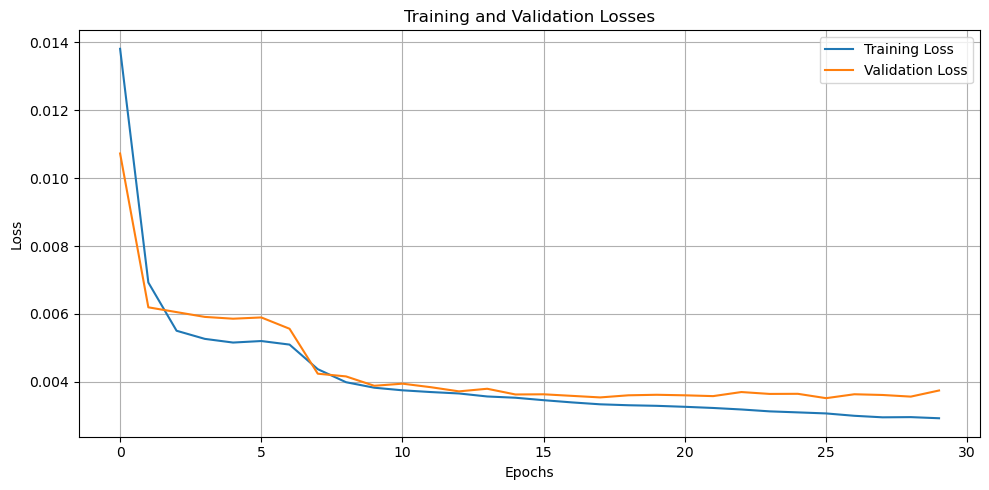

Finished training 2024-04-20_base_model_comparison_l1Loss_batch32_CNN.
Using 2 GPUs!
Training 2024-04-20_base_model_comparison_l1Loss_batch32_SmallUNet...
Epoch [1/30], Loss: 0.0118
Validation Loss: 0.0058
Epoch [2/30], Loss: 0.0035
Validation Loss: 0.0031
Epoch [3/30], Loss: 0.0030
Validation Loss: 0.0036
Epoch [4/30], Loss: 0.0030
Validation Loss: 0.0030
Epoch [5/30], Loss: 0.0028
Validation Loss: 0.0028
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_SmallUNet/model_epoch_5.pth
Losses saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_SmallUNet/losses_epoch_5.json
Epoch [6/30], Loss: 0.0027
Validation Loss: 0.0031
Epoch [7/30], Loss: 0.0027
Validation Loss: 0.0032
Epoch [8/30], Loss: 0.0027
Validation Loss: 0.0030
Epoch [9/30], Loss: 0.0027
Validation Loss: 0.0028
Epoch [10/30], Loss: 0.0026
Validation Loss: 0.0029
Model saved to /home/tom/repos/dyna-landsli

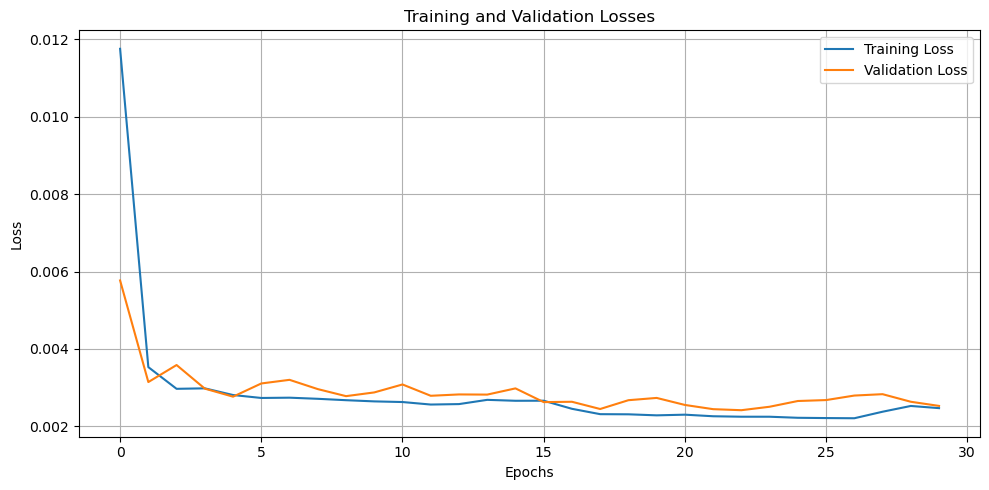

Finished training 2024-04-20_base_model_comparison_l1Loss_batch32_SmallUNet.
Using 2 GPUs!
Training 2024-04-20_base_model_comparison_l1Loss_batch32_MedUNet...
Epoch [1/30], Loss: 0.0135
Validation Loss: 0.0079
Epoch [2/30], Loss: 0.0049
Validation Loss: 0.0041
Epoch [3/30], Loss: 0.0039
Validation Loss: 0.0035
Epoch [4/30], Loss: 0.0036
Validation Loss: 0.0035
Epoch [5/30], Loss: 0.0035
Validation Loss: 0.0042
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_MedUNet/model_epoch_5.pth
Losses saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_MedUNet/losses_epoch_5.json
Epoch [6/30], Loss: 0.0034
Validation Loss: 0.0041
Epoch [7/30], Loss: 0.0034
Validation Loss: 0.0036
Epoch [8/30], Loss: 0.0034
Validation Loss: 0.0029
Epoch [9/30], Loss: 0.0033
Validation Loss: 0.0037
Epoch [10/30], Loss: 0.0033
Validation Loss: 0.0038
Model saved to /home/tom/repos/dyna-landsli

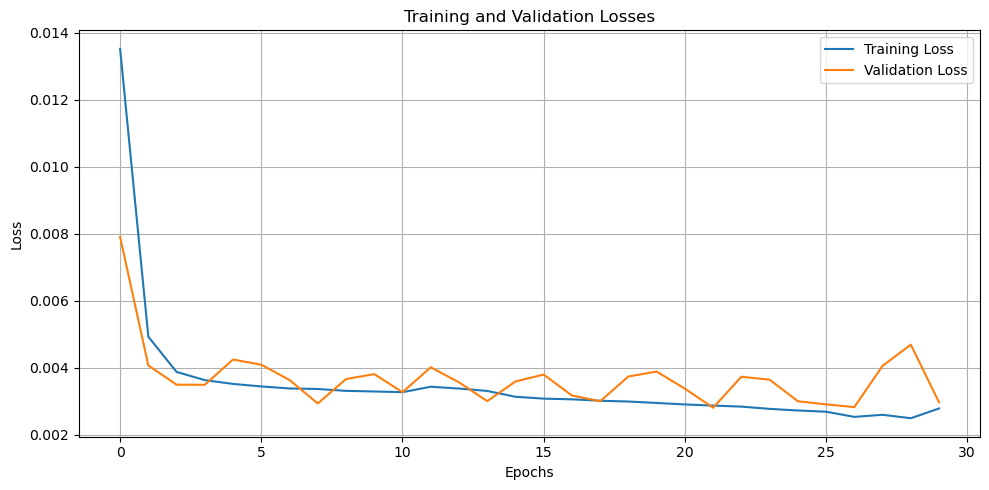

Finished training 2024-04-20_base_model_comparison_l1Loss_batch32_MedUNet.
Using 2 GPUs!
Training 2024-04-20_base_model_comparison_l1Loss_batch32_LargeUNet...
Epoch [1/30], Loss: 0.0137
Validation Loss: 0.0052
Epoch [2/30], Loss: 0.0040
Validation Loss: 0.0035
Epoch [3/30], Loss: 0.0032
Validation Loss: 0.0031
Epoch [4/30], Loss: 0.0028
Validation Loss: 0.0029
Epoch [5/30], Loss: 0.0027
Validation Loss: 0.0029
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_LargeUNet/model_epoch_5.pth
Losses saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_LargeUNet/losses_epoch_5.json
Epoch [6/30], Loss: 0.0026
Validation Loss: 0.0029
Epoch [7/30], Loss: 0.0026
Validation Loss: 0.0028
Epoch [8/30], Loss: 0.0025
Validation Loss: 0.0028
Epoch [9/30], Loss: 0.0025
Validation Loss: 0.0028
Epoch [10/30], Loss: 0.0025
Validation Loss: 0.0026
Model saved to /home/tom/repos/dyna-lan

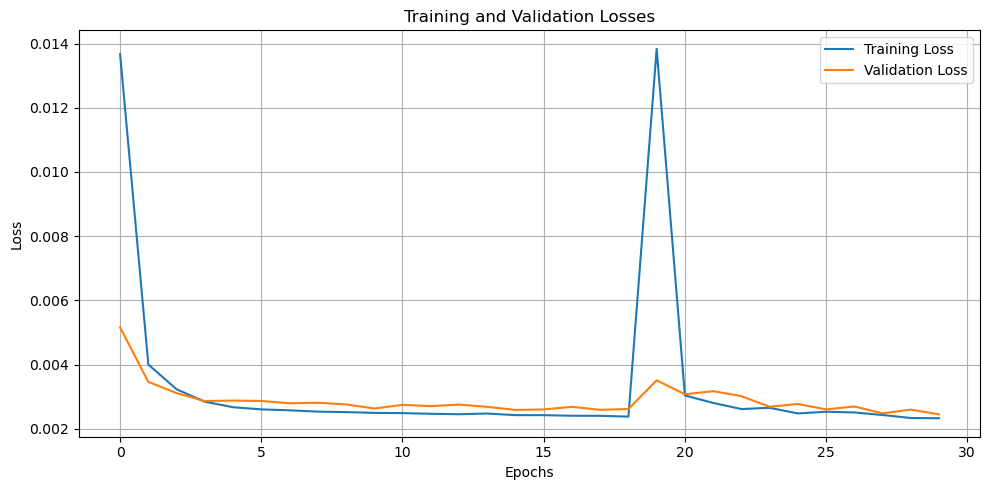

Finished training 2024-04-20_base_model_comparison_l1Loss_batch32_LargeUNet.


In [9]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}.")

# Train each model
for model_info in models:
    
    model = model_info['model']

    # Check if multiple GPUs are available and wrap the model using nn.DataParallel
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        # This will wrap the model for use with multiple GPUs
        model = torch.nn.DataParallel(model)
    
    # Move model to the appropriate device
    model.to(device)
    
    # Define the loss function and optimizer
    # criterion = nn.MSELoss()
    criterion = nn.L1Loss()
    # criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    # Initialize the trainer
    model_name = model_info['name']
    trainer = TrainerPairs(model, optimizer, criterion, device, model_name=model_name, checkpoint_dir=checkpoint_dir)
    
    # Train the model
    print(f"Training {model_name}...")
    trainer.train(train_loader, val_loader, epochs=epochs, checkpoint_interval=5)
    
    print(f"Finished training {model_name}.")

In [10]:
# # Evaluate the model on the test set
# print("Plotting losses...")
# trainer.plot_losses()

In [11]:
# # Evaluate the model on the test set
# print("Evaluating the model on the test set...")
# trainer.test(test_loader)


In [12]:
# trainer.plot_predictions(test_loader, num_predictions=1)

In [13]:
# model_number = '00015'
# state_number = 2
# num_timesteps = 3


# input_tensor = trainer.create_inference_input(root_dir=root_dir, 
#                                               model_number=model_number, 
#                                               state_number=state_number, 
#                                               array_size=256)

In [14]:
# inferred = trainer.infer(input_tensor, num_timesteps=num_timesteps)

In [15]:
# for key, value in inferred.items():
#     print(f"Key: {key} -> Type of value: {type(value).__name__}")